In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

2025-06-27 10:41:24.663933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751020885.169622    3914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751020885.286471    3914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# Specify the directory containing the UCF50 dataset
DATASET_DIR = "/kaggle/input/ucf50/UCF50"

os.path.exists(DATASET_DIR)

True

In [4]:
all_class_names = os.listdir(DATASET_DIR)

len(all_class_names)

50

In [5]:
# Global constant variables -> 
NO_OF_CLASSES = 5
CLASSES_LIST = all_class_names[:NO_OF_CLASSES]

# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
SEQUENCE_LENGTH = 15

# set drop out rate
DROPOUT_RATE = 0.2

# set datas
MAX_VIDEO_PER_CLASS = 50

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 50
BATCH_SIZE = 5
VALIDATION_SPLIT = 0.20


# give a name of the model to save
MODEL_NAME = "Xception"

In [6]:
# # Create a Matplotlib figure and specify the size of the figure
# plt.figure(figsize=(20, 20))

# # Get the names of all classes/categories in UCF50
# all_classes_names = os.listdir(DATASET_DIR)

# # Check if the directory contains classes
# if not all_classes_names:
#     raise ValueError(f"No classes found in {DATASET_DIR}. Please ensure the dataset is extracted correctly.")

# # Generate a list of 20 random values, ensuring we don't sample more than available classes
# random_range = random.sample(range(len(all_classes_names)), min(20, len(all_classes_names)))

# # Iterating through all the generated random values
# for counter, random_index in enumerate(random_range, 1):
#     selected_class_Name = all_classes_names[random_index]
#     video_files_names_list = os.listdir(f'{DATASET_DIR}/{selected_class_Name}')
#     selected_video_file_name = random.choice(video_files_names_list)
#     video_reader = cv2.VideoCapture(f'{DATASET_DIR}/{selected_class_Name}/{selected_video_file_name}')
#     _, bgr_frame = video_reader.read()
#     video_reader.release()
#     rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
#     cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
#     plt.subplot(5, 4, counter)
#     plt.imshow(rgb_frame)
#     plt.axis('off')
# plt.show()

In [7]:
# frame extraction
import cv2
import numpy as np
import os

def frames_extraction(video_path, 
                      sequence_length=SEQUENCE_LENGTH, 
                      image_height=IMAGE_HEIGHT, 
                      image_width=IMAGE_WIDTH):
    '''
    This function extracts the required frames from a video, resizes and normalizes them for model input.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
        sequence_length: Number of frames to extract per video (default: 20).
        image_height: Height to resize frames to (default: 224 for Xception).
        image_width: Width to resize frames to (default: 224 for Xception).
    Returns:
        frames_list: A list containing the resized and normalized frames of the video, or None if extraction fails.
    '''
    # Declare a list to store video frames
    frames_list = []

    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    # Read the video file using VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure the video has enough frames
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None

    # Calculate the interval after which frames will be sampled
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Iterate to extract the specified number of frames
    for frame_counter in range(sequence_length):
        # Set the current frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read the frame
        success, frame = video_reader.read()

        # Check if the frame was read successfully
        if not success or frame is None:
            print(f"Warning: Failed to read frame {frame_counter} from {video_path}")
            break

        # Resize the frame to the specified dimensions
        try:
            resized_frame = cv2.resize(frame, (image_width, image_height))
        except Exception as e:
            print(f"Error resizing frame {frame_counter} from {video_path}: {e}")
            break

        # Normalize the frame to [0, 1] for model input
        normalized_frame = resized_frame / 255.0

        # Append the normalized frame to the list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object
    video_reader.release()

    # Ensure the correct number of frames is extracted
    if len(frames_list) != sequence_length:
        print(f"Warning: Extracted {len(frames_list)} frames instead of {sequence_length} from {video_path}")
        return None

    # Convert to numpy array for consistency
    frames_list = np.array(frames_list)

    return frames_list

In [8]:
# RUN create dataset function definition

import os
import numpy as np

def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None):
    '''
    This function extracts data for selected classes and creates the dataset.
    Args:
        dataset_dir: The directory containing the UCF-50 dataset (e.g., "/kaggle/working/UCF50_dataset/UCF50").
        classes_list: List of class names to include in the dataset.
        sequence_length: Number of frames to extract per video (default: 20).
        image_height: Height to resize frames to (default: 224 for Xception).
        image_width: Width to resize frames to (default: 224 for Xception).
        max_videos_per_class: Maximum number of videos to process per class (optional, for testing).
    Returns:
        features: A numpy array of extracted frame sequences with shape (n_videos, sequence_length, image_height, image_width, 3).
        labels: A numpy array of class indexes.
        video_files_paths: A list of video file paths.
    '''
    # Initialize lists to store features, labels, and video file paths
    features = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)

            # Extract frames using the updated frames_extraction function
            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            features.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not features:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    
    features = np.asarray(features)
    labels = np.array(labels)

    print(f"Dataset created with {len(features)} videos")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")

    return features, labels

In [9]:
# RUN Create the dataset with explicit parameters
try:
    features, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        
        # Limit to 10 videos per class to manage memory
        max_videos_per_class=MAX_VIDEO_PER_CLASS  
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

Extracting Data of Class: HorseRace
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: Biking
Extracting Data of Class: TaiChi
Extracting Data of Class: Punch
Dataset created with 250 videos
Features shape: (250, 15, 224, 224, 3)
Labels shape: (250,)


In [10]:
# RUN Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

In [12]:
# free space in ram memory
del features, labels

In [13]:
# RUN create model function definition

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, Flatten, LSTM, Dropout, Dense

def create_xception_lstm_model(sequence_length=SEQUENCE_LENGTH, 
                               image_height=IMAGE_HEIGHT, 
                               image_width=IMAGE_WIDTH, 
                               classes_list=None):
    '''
    Constructs the Xception + LSTM model for video classification.
    Args:
        sequence_length: Number of frames per video (default: 20).
        image_height: Height of input frames (default: 224).
        image_width: Width of input frames (default: 224).
        classes_list: List of class names for output layer (required).
    Returns:
        model: The constructed Xception + LSTM model.
    '''
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")

    # Initialize the Sequential model
    model = Sequential(name="Xception_LSTM_Model")

    try:
        # Load Xception model with pre-trained ImageNet weights
        print("Loading Xception base model...")
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(image_height, image_width, 3)
        )

        # Freeze the base model to reduce memory usage and training time
        base_model.trainable = False

        # Create the feature extractor
        feature_extractor = Model(
            inputs=base_model.input,
            outputs=base_model.output,
            name="Xception_Feature_Extractor"
        )

        # Add TimeDistributed wrapper to apply Xception to each frame
        model.add(TimeDistributed(
            feature_extractor,
            input_shape=(sequence_length, image_height, image_width, 3),
            name="TimeDistributed_Xception"
        ))

        # Flatten the extracted features
        model.add(TimeDistributed(Flatten(), name="TimeDistributed_Flatten"))

        # Add LSTM layer with fewer units to reduce memory usage
        model.add(LSTM(64, activation='relu', return_sequences=False, name="LSTM_Layer"))

        # Add Dropout to prevent overfitting
        model.add(Dropout(DROPOUT_RATE, name="Dropout_Layer"))

        # Output layer for classification
        model.add(Dense(len(classes_list), activation="softmax", name="Output_Layer"))

        # Print model summary
        print("Model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        return None

In [14]:
# donwload model weights
from tensorflow.keras.applications import Xception
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...


I0000 00:00:1751020926.908086    3914 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751020926.908881    3914 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Weights loaded successfully!


In [15]:
# RUN
import gc
tf.keras.backend.clear_session()
gc.collect()

0

In [16]:
# Clear previous session to free memory
tf.keras.backend.clear_session()

# Create the model
xlstm_model = create_xception_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST
)

# Check if model was created successfully
if xlstm_model is None:
    print("Failed to create model. Check error messages above.")
else:
    print("Model Created Successfully!")

Loading Xception base model...
Model architecture created successfully!


Model: "Xception_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ TimeDistributed_Xception             │ (None, 15, 7, 7, 2048)      │      20,861,480 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TimeDistributed_Flatten              │ (None, 15, 100352)          │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │      25,706,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_Layer (Dropout)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,568,557 (177.64 MB)

 Trainable params: 25,707,077 (98.06 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Model Created Successfully!


In [17]:
# Plot the structure of the contructed model.
plot_model(xlstm_model, to_file = f'{MODEL_NAME}_model_Plot.png', show_shapes = True, show_layer_names = True)

print(f"{MODEL_NAME} Model Plot saved successfully...")

Xception Model Plot saved successfully...


In [19]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 7, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', 
                    optimizer = 'Adam', 
                    metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = xlstm_model.fit(x = features_train,
                                                  y = labels_train,
                                                  epochs = EPOCHS,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True,
                                                  validation_split = VALIDATION_SPLIT,
                                                  callbacks = [early_stopping_callback])

Epoch 1/50


I0000 00:00:1751021136.127241    4950 service.cc:148] XLA service 0x7d3384011520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751021136.128778    4950 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751021136.128805    4950 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751021147.776447    4950 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751021160.413585    4950 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.2082 - loss: 363.0646 - val_accuracy: 0.3500 - val_loss: 273.0802
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 675ms/step - accuracy: 0.2996 - loss: 262.5547 - val_accuracy: 0.2250 - val_loss: 477.7531
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 688ms/step - accuracy: 0.2879 - loss: 436.4681 - val_accuracy: 0.2500 - val_loss: 296.5583
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 665ms/step - accuracy: 0.1803 - loss: 433.2321 - val_accuracy: 0.2750 - val_loss: 418.9865
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 668ms/step - accuracy: 0.2790 - loss: 549.3647 - val_accuracy: 0.2250 - val_loss: 135.1395
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 677ms/step - accuracy: 0.3675 - loss: 188.7583 - val_accuracy: 0.3750 - val_loss: 119.3328
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.3619 - loss: 183.4146 - val_accuracy: 0.2750 - val_loss: 107.5827
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.3023 - loss: 17

In [ ]:
# previous code
# model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

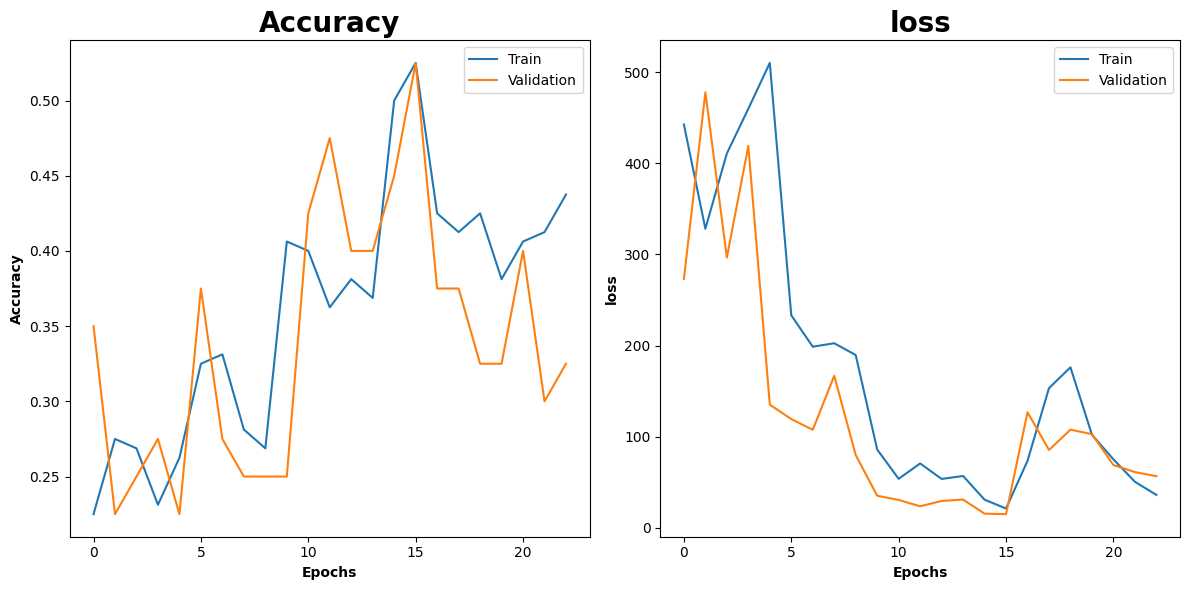

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Accuracy",weight="bold",fontsize=20)
plt.plot(convlstm_model_training_history.history["accuracy"])
plt.plot(convlstm_model_training_history.history["val_accuracy"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs",weight="bold")
plt.ylabel("Accuracy",weight="bold")
plt.subplot(1,2,2)
plt.title("loss",weight="bold",fontsize=20)
plt.plot(convlstm_model_training_history.history["loss"])
plt.plot(convlstm_model_training_history.history["val_loss"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs",weight="bold")
plt.ylabel("loss",weight="bold")
plt.tight_layout()
plt.show()

In [21]:
# Evaluate the trained model.

# Create a dataset from your test features and labels
test_dataset = tf.data.Dataset.from_tensor_slices((features_test, labels_test))
test_dataset = test_dataset.batch(8)  # Try 4, 8, 16 depending on your memory

# Evaluate using the dataset
model_evaluation_history = xlstm_model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5551 - loss: 12.9787


In [ ]:
# # Get the loss and accuracy from model_evaluation_history.
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# # Define the string date format.
# # Get the current Date and Time in a DateTime Object.
# # Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
# model_file_name = f'xlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# # Save your Model.
# xlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'new/Output-SeqLen.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video("/content/Test Video.mp4", output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
import cv2
import numpy as np
from collections import deque
from moviepy.editor import VideoFileClip

# Define model-related constants
SEQUENCE_LENGTH = 20  # Set this based on your model
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Set this based on your training
CLASSES_LIST = ['Walking', 'Running', 'Jumping']  # Replace with your actual class names

# Load your trained model (assumes it's already loaded globally as convlstm_model)
# convlstm_model = ... (your model loading code here)

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    Perform action recognition on a video using the LRCN model.

    Args:
    - video_file_path: str, input video path
    - output_file_path: str, where to save output video with predictions
    - SEQUENCE_LENGTH: int, number of frames per prediction sequence
    '''

    # Initialize the VideoCapture object
    video_reader = cv2.VideoCapture(video_file_path)

    # Get video properties
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Create VideoWriter object
    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (original_video_width, original_video_height)
    )

    # Frame queue and predicted class label
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while True:
        ok, frame = video_reader.read()

        # Break loop if no frame is returned
        if not ok or frame is None:
            break

        # Resize and normalize frame
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0

        # Append to queue
        frames_queue.append(normalized_frame)

        # Predict action when enough frames are collected
        if len(frames_queue) == SEQUENCE_LENGTH:
            input_batch = np.expand_dims(frames_queue, axis=0)  # Shape: (1, SEQUENCE_LENGTH, H, W, 3)
            predicted_probabilities = convlstm_model.predict(input_batch)[0]
            predicted_label = np.argmax(predicted_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Overlay prediction on original frame
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)

        # Write frame to output
        video_writer.write(frame)

    # Release resources
    video_reader.release()
    video_writer.release()
    print(f"Prediction complete. Output saved to {output_file_path}")

# ==== Run the prediction ====

# Example usage
input_video_path = "/content/Test Video.mp4"
output_video_path = "new/Output-SeqLen.mp4"

# Make sure output folder exists
import os
os.makedirs(os.path.dirname(output_video_path), exist_ok=True)

# Run prediction
predict_on_video(input_video_path, output_video_path, SEQUENCE_LENGTH)

# Display the output video
VideoFileClip(output_video_path, audio=False, target_resolution=(300, None)).ipython_display()


In [ ]:
!wget https://drive.google.com/file/d/1c7j6_zgCsC1wq1Zxg-gZE_6Zk_Fo-UZj/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')